In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

# === Funzione per estrarre le features dal livello layer3 e visualizzare mappe di attivazione ===
def extract_resnet_layer3_features_and_visualize(img_path):
    # Carica l'immagine
    img = Image.open(img_path)
    
    # Pre-processa l'immagine per ResNet (trasformazioni standard)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img).unsqueeze(0)  # Aggiungi batch dimension

    # Carica la ResNet pre-addestrata
    resnet = models.resnet50(pretrained=True)
    resnet.eval()

    # Definire il hook per estrarre i dati dal layer3
    def hook_fn(module, input, output):
        # Salva l'output del layer3
        layer3_output.append(output)

    # Registriamo il hook al livello layer3 (ResNet ha layer3 in 'layer3')
    layer3_output = []
    hook = resnet.layer3[0].register_forward_hook(hook_fn)

    # Passa l'immagine attraverso il modello
    with torch.no_grad():
        resnet(img_tensor)

    # Rimuovi il hook
    hook.remove()
    return features

# === Esecuzione ===
img_path = "Part1/brain_glioma/brain_glioma_0002.jpg"
features = extract_resnet_layer3_features_and_visualize(img_path)

print(f"Vettore delle features: {features[:10]}")  # Mostra i primi 10 valori


Vettore delle features: [0.10401522 0.05138333 0.016945   0.10827071 0.02337234 0.01038369
 0.04877223 0.         0.06606087 0.01735999]


Task 2:

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np

# Funzione per caricare l'immagine e fare la pre-elaborazione
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor

# Funzione per estrarre le caratteristiche dal livello "layer3" della ResNet
def extract_resnet_features(img_tensor, model):
    def hook_fn(module, input, output):
        hook_fn.features = output

    hook = model.layer3[0].register_forward_hook(hook_fn)
    model(img_tensor)
    hook.remove()

    features = hook_fn.features.squeeze()
    return features

# Funzione per estrarre la media su ciascuna mappa di attivazione
def extract_and_process_image(img_path, model):
    img_tensor = preprocess_image(img_path)
    features = extract_resnet_features(img_tensor, model)
    features_vector = features.detach().mean(dim=[1, 2]).cpu().numpy()
    return features_vector

# Funzione per processare tutte le immagini in più sottocartelle
def process_multiple_folders(base_folder, subfolders, model):
    features_list = []
    filenames_list = []
    labels_list = []

    for subfolder in subfolders:
        subfolder_path = os.path.join(base_folder, subfolder)
        print(f"[INFO] Elaboro la sottocartella: {subfolder}")

        for filename in os.listdir(subfolder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(subfolder_path, filename)
                print(f"[INFO] Elaboro: {filename}")
                features = extract_and_process_image(img_path, model)
                features_list.append(features)
                filenames_list.append(filename)
                labels_list.append(subfolder)

    return np.array(features_list), np.array(filenames_list), np.array(labels_list)

# === Inizializzazione del modello ===
model = models.resnet50(pretrained=True)
model.eval()

# === Esecuzione ===
base_folder = "Part1"
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]
features, filenames, labels = process_multiple_folders(base_folder, subfolders, model)

# === Salvataggio in .npz ===
np.savez("resnet_features_all.npz", features=features, filenames=filenames, labels=labels)
print("[SALVATO] Dati ResNet salvati in resnet_features_all.npz")
print(f"[FINE] Elaborate {len(filenames)} immagini da {len(subfolders)} classi.")

[INFO] Elaboro la sottocartella: brain_glioma
[INFO] Elaboro: brain_glioma_0717.jpg
[INFO] Elaboro: brain_glioma_0071.jpg
[INFO] Elaboro: brain_glioma_0065.jpg
[INFO] Elaboro: brain_glioma_0703.jpg
[INFO] Elaboro: brain_glioma_0059.jpg
[INFO] Elaboro: brain_glioma_0918.jpg
[INFO] Elaboro: brain_glioma_0930.jpg
[INFO] Elaboro: brain_glioma_0924.jpg
[INFO] Elaboro: brain_glioma_0273.jpg
[INFO] Elaboro: brain_glioma_0515.jpg
[INFO] Elaboro: brain_glioma_0501.jpg
[INFO] Elaboro: brain_glioma_0267.jpg
[INFO] Elaboro: brain_glioma_0529.jpg
[INFO] Elaboro: brain_glioma_0298.jpg
[INFO] Elaboro: brain_glioma_0307.jpg
[INFO] Elaboro: brain_glioma_0461.jpg
[INFO] Elaboro: brain_glioma_0475.jpg
[INFO] Elaboro: brain_glioma_0313.jpg
[INFO] Elaboro: brain_glioma_0449.jpg
[INFO] Elaboro: brain_glioma_0663.jpg
[INFO] Elaboro: brain_glioma_0105.jpg
[INFO] Elaboro: brain_glioma_0111.jpg
[INFO] Elaboro: brain_glioma_0677.jpg
[INFO] Elaboro: brain_glioma_0887.jpg
[INFO] Elaboro: brain_glioma_0139.jpg
[INF

Task 3:

/Users/giari/Desktop/uni/MDB/DBmulti/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/giari/Desktop/uni/MDB/DBmulti/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


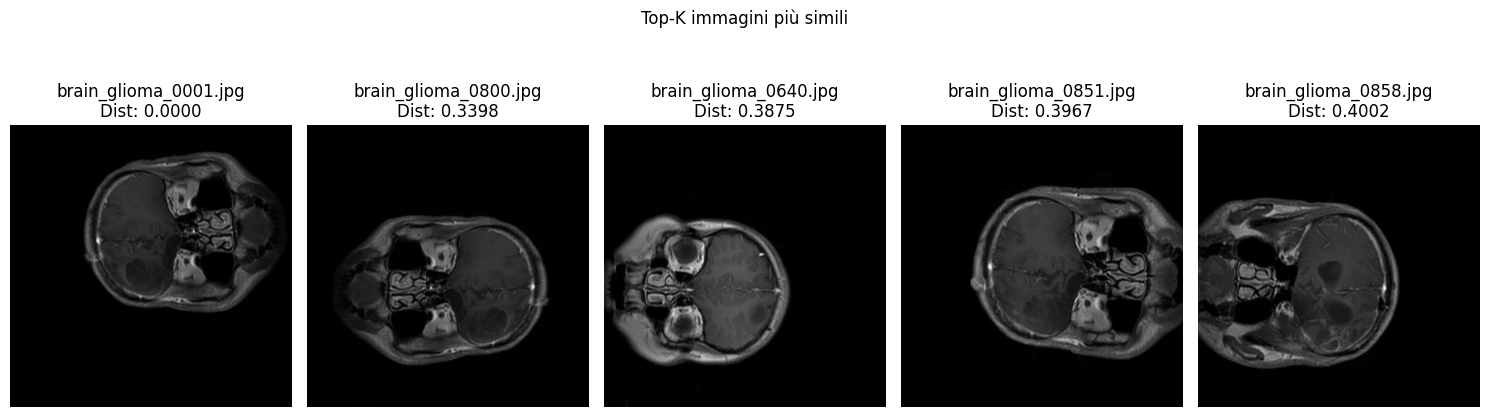

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import models
from torchvision import transforms

# === Funzioni già definite nel tuo codice ===
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor

def extract_resnet_features(img_tensor, model):
    def hook_fn(module, input, output):
        hook_fn.features = output

    hook = model.layer3[0].register_forward_hook(hook_fn)
    model(img_tensor)
    hook.remove()

    features = hook_fn.features.squeeze()
    return features

def extract_and_process_image(img_path, model):
    img_tensor = preprocess_image(img_path)
    features = extract_resnet_features(img_tensor, model)
    features_vector = features.detach().mean(dim=[1, 2]).cpu().numpy()
    return features_vector

# === Funzione per trovare immagini simili ===
def find_top_k_similar(query_img_path, k, features_npz_path, model, image_folder):
    # Carica le feature, nomi file e label salvati
    data = np.load(features_npz_path)
    features = data['features']
    filenames = data['filenames']
    labels = data['labels']

    # Estrai feature per immagine di query
    query_feature = extract_and_process_image(query_img_path, model)

    # Calcola distanza euclidea tra query e tutte le immagini salvate
    dists = np.linalg.norm(features - query_feature, axis=1)

    # Trova gli indici delle k immagini più simili (con distanza minore)
    top_k_indices = np.argsort(dists)[:k]

    # Visualizza risultati
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_k_indices):
        img_path = os.path.join(image_folder, labels[idx], filenames[idx])
        img = Image.open(img_path).convert("RGB")
        plt.subplot(1, k, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{filenames[idx]}\nDist: {dists[idx]:.4f}")
    plt.suptitle("Top-K immagini più simili")
    plt.tight_layout()
    plt.show()

# === Esempio di utilizzo ===

# === Parametri di esecuzione ===
query_image_path = "Part1/brain_glioma/brain_glioma_0001.jpg"  # Modifica con il percorso della tua immagine
k = 5
features_npz = "resnet_features_all.npz"
base_folder = "Part1"

# === Caricamento modello ResNet50 pre-addestrato ===
model = models.resnet50(pretrained=True)
model.eval()

# === Esecuzione della ricerca delle immagini più simili ===
find_top_k_similar(query_image_path, k, features_npz, model, base_folder)



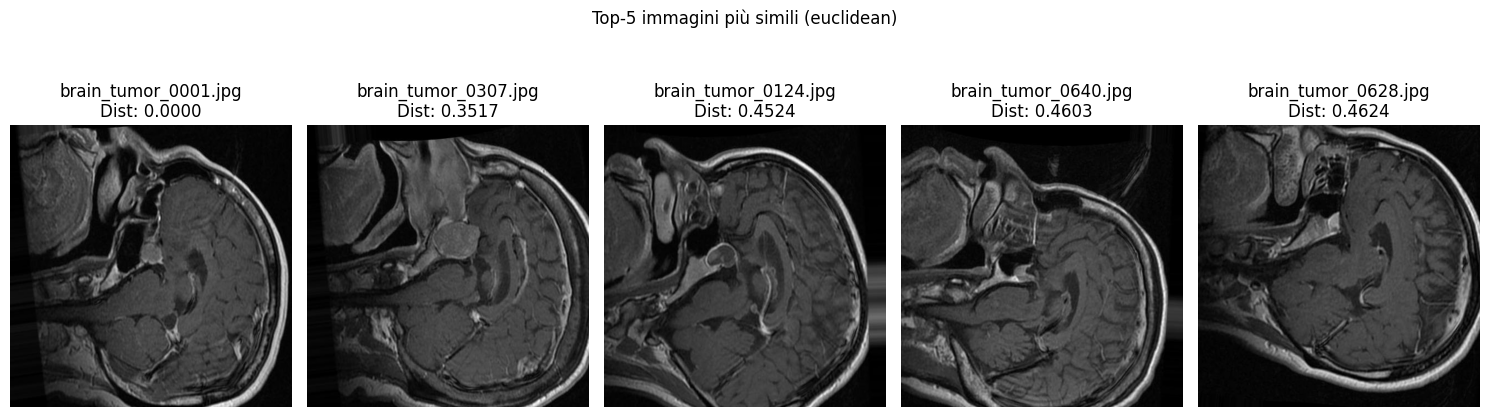

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import models
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity

# --- Le funzioni preprocess_image, extract_resnet_features, extract_and_process_image restano identiche ---

def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor

def extract_resnet_features(img_tensor, model):
    def hook_fn(module, input, output):
        hook_fn.features = output

    hook = model.layer3[0].register_forward_hook(hook_fn)
    model(img_tensor)
    hook.remove()

    features = hook_fn.features.squeeze()
    return features

def extract_and_process_image(img_path, model):
    img_tensor = preprocess_image(img_path)
    features = extract_resnet_features(img_tensor, model)
    features_vector = features.detach().mean(dim=[1, 2]).cpu().numpy()
    return features_vector

# --- Funzione con scelta metrica ---

def find_top_k_similar(query_img_path, k, features_npz_path, model, image_folder, metric="euclidean"):
    """
    Trova e visualizza le k immagini più simili rispetto all'immagine di query.

    Parametri:
    - query_img_path: percorso immagine di query
    - k: numero di immagini simili da mostrare
    - features_npz_path: file .npz con features, filenames, labels
    - model: modello ResNet già caricato
    - image_folder: cartella base delle immagini (per ricostruire i path)
    - metric: "euclidean" o "cosine" (default euclidean)
    """

    # Carica dati
    data = np.load(features_npz_path)
    features = data['features']
    filenames = data['filenames']
    labels = data['labels']

    # Estrai feature per immagine query
    query_feature = extract_and_process_image(query_img_path, model).reshape(1, -1)

    if metric == "euclidean":
        # Distanza euclidea
        dists = np.linalg.norm(features - query_feature, axis=1)
        # Più piccoli sono migliori (vicinanza)
        top_k_indices = np.argsort(dists)[:k]

    elif metric == "cosine":
        # Similarità coseno
        sim = cosine_similarity(query_feature, features)[0]  # shape: (num_features,)
        # Più alti sono migliori (similarità)
        top_k_indices = np.argsort(sim)[::-1][:k]

    else:
        raise ValueError("Metric must be 'euclidean' or 'cosine'")

    # Visualizzazione
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_k_indices):
        img_path = os.path.join(image_folder, labels[idx], filenames[idx])
        img = Image.open(img_path).convert("RGB")
        plt.subplot(1, k, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if metric == "euclidean":
            plt.title(f"{filenames[idx]}\nDist: {dists[idx]:.4f}")
        else:
            plt.title(f"{filenames[idx]}\nSim: {sim[idx]:.4f}")

    plt.suptitle(f"Top-{k} immagini più simili ({metric})")
    plt.tight_layout()
    plt.show()

# === Esempio di uso ===

# === Caricamento modello ResNet50 pre-addestrato ===
model = models.resnet50(pretrained=True)
model.eval()

# === Parametri ===
query_image_path = "Part1/brain_tumor/brain_tumor_0001.jpg"  # Sostituisci con il percorso corretto
k = 5
features_npz = "resnet_features_all.npz"
base_folder = "Part1"

# === Chiamata con distanza euclidea ===
# find_top_k_similar(query_image_path, k, features_npz, model, base_folder, metric="euclidean")

# === Chiamata con similarità coseno ===
find_top_k_similar(query_image_path, k, features_npz, model, base_folder, metric="euclidean")


Task 4:

In [33]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_metric(query_feat, target_feats, metric="euclidean"):
    """
    Calcola la distanza o similarità tra query_feat e un set di target_feats.
    """
    query_feat = query_feat.reshape(1, -1)
    if metric == "euclidean":
        return np.linalg.norm(target_feats - query_feat, axis=1)
    elif metric == "cosine":
        return cosine_similarity(query_feat, target_feats)[0]
    else:
        raise ValueError("Metric must be 'euclidean' or 'cosine'")

def predict_top_k_labels_distance_mean(query_img_path, k, model, metric="euclidean"):
    """
    Strategia 1: etichetta più vicina in media nel feature space.
    """
    data = np.load("resnet_features_all.npz")
    features = data['features']
    labels = data['labels']

    query_feat = extract_and_process_image(query_img_path, model)

    unique_labels = np.unique(labels)
    avg_scores = []

    for label in unique_labels:
        class_feats = features[labels == label]
        scores = compute_metric(query_feat, class_feats, metric)
        avg_scores.append(scores.mean())

    # Ordinamento (euclidea: valori più piccoli = migliori; cosine: valori più grandi = migliori)
    if metric == "euclidean":
        sorted_indices = np.argsort(avg_scores)
    else:  # cosine
        sorted_indices = np.argsort(avg_scores)[::-1]

    print(f"--- Top-{k} etichette - Distanza media ({metric}) ---")
    for i in range(min(k, len(unique_labels))):
        idx = sorted_indices[i]
        print(f"{unique_labels[idx]} \t Score medio: {avg_scores[idx]:.4f}")

def predict_top_k_labels_prototype(query_img_path, k, model, metric="euclidean"):
    """
    Strategia 2: distanza/similarità rispetto al prototipo (media) della classe.
    """
    data = np.load("resnet_features_all.npz")
    features = data['features']
    labels = data['labels']

    query_feat = extract_and_process_image(query_img_path, model)

    unique_labels = np.unique(labels)
    prototypes = []
    for label in unique_labels:
        class_feats = features[labels == label]
        prototypes.append(class_feats.mean(axis=0))
    prototypes = np.vstack(prototypes)

    scores = compute_metric(query_feat, prototypes, metric)

    if metric == "euclidean":
        sorted_indices = np.argsort(scores)
    else:
        sorted_indices = np.argsort(scores)[::-1]

    print(f"--- Top-{k} etichette - Prototipo classe ({metric}) ---")
    for i in range(min(k, len(unique_labels))):
        idx = sorted_indices[i]
        print(f"{unique_labels[idx]} \t Score: {scores[idx]:.4f}")

def task4_predict_labels(query_img_path, k, model, metric="euclidean"):
    assert k <= 2, "k deve essere <= 2"
    print(f"Predizione top-{k} per immagine '{query_img_path}' usando metrica '{metric}'")
    predict_top_k_labels_distance_mean(query_img_path, k, model, metric)
    print()
    predict_top_k_labels_prototype(query_img_path, k, model, metric)


In [34]:
from torchvision import models

model = models.resnet50(pretrained=True)
model.eval()

query_img = "Part2/brain_glioma/brain_glioma_1112.jpg"

task4_predict_labels(query_img, k=2, model=model, metric="euclidean")
print()
task4_predict_labels(query_img, k=2, model=model, metric="cosine")


/Users/giari/Desktop/uni/MDB/DBmulti/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/giari/Desktop/uni/MDB/DBmulti/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predizione top-2 per immagine 'Part2/brain_glioma/brain_glioma_1112.jpg' usando metrica 'euclidean'
--- Top-2 etichette - Distanza media (euclidean) ---
brain_glioma 	 Score medio: 0.6539
brain_menin 	 Score medio: 0.7890

--- Top-2 etichette - Prototipo classe (euclidean) ---
brain_glioma 	 Score: 0.3942
brain_menin 	 Score: 0.5319

Predizione top-2 per immagine 'Part2/brain_glioma/brain_glioma_1112.jpg' usando metrica 'cosine'
--- Top-2 etichette - Distanza media (cosine) ---
brain_glioma 	 Score medio: 0.9750
brain_menin 	 Score medio: 0.9644

--- Top-2 etichette - Prototipo classe (cosine) ---
brain_glioma 	 Score: 0.9911
brain_menin 	 Score: 0.9839


Task 5:

In [35]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans

def task5_latent_semantics_resnet(feature_model_path, technique, k):
    """
    Estrae i top-k concetti latenti da uno spazio di feature ResNet usando SVD, LDA o KMeans.
    Salva i risultati su file e visualizza lo spazio latente.

    Parametri:
    ------------
    - feature_model_path: percorso file .npz (es. "resnet_layer3.npz")
    - technique: "svd", "lda", "kmeans"
    - k: numero componenti/cluster da estrarre
    """
    # === Caricamento delle feature ===
    data = np.load(feature_model_path, allow_pickle=True)
    feature_matrix = data['features']
    filenames = data['filenames']
    labels = data['labels']

    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k, random_state=42)
        X_transformed = model.fit_transform(feature_matrix)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(labels)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feature_matrix, labels)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feature_matrix)
        components = model.cluster_centers_
        X_transformed = model.transform(feature_matrix)
        method = "kmeans"
    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    # === Visualizzazione ===
    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, labels, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feature_matrix, labels, k)

    # === Output file ===
    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = f"latent_semantics_{method}_{base_name}_k{k}.txt"

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feature_matrix @ components[i].T
            else:
                weights = -X_transformed[:, i]  # distanza inversa

            sorted_idx = np.argsort(-np.abs(weights))
            for idx in sorted_idx:
                f.write(f"{filenames[idx]} | Peso: {weights[idx]:.4f} | Classe: {labels[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")


In [36]:
def plot_latent_space_2d(X_transformed, labels, technique, k):
    """Visualizza la proiezione 2D dello spazio latente."""
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    """Visualizza i cluster KMeans in 2D usando SVD per proiezione."""
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()


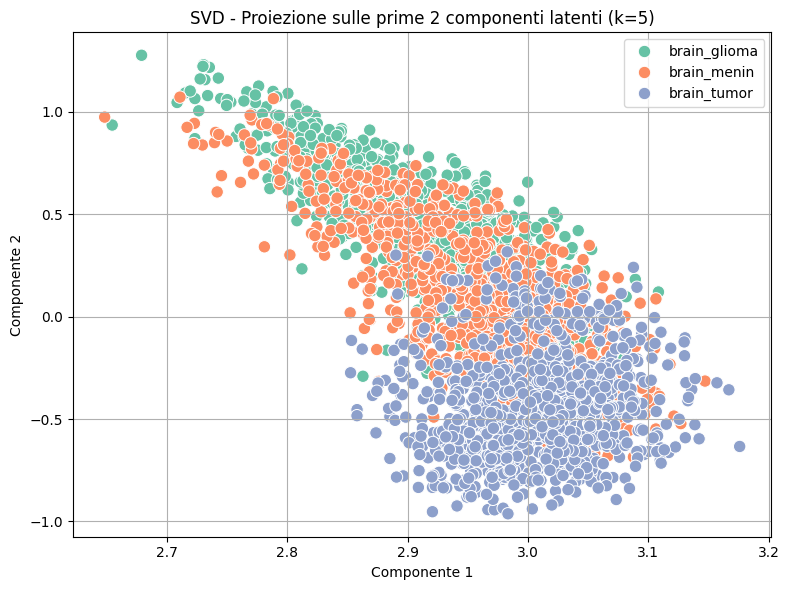

[SALVATO] Latent semantics salvati in: latent_semantics_svd_resnet_features_all_k5.txt


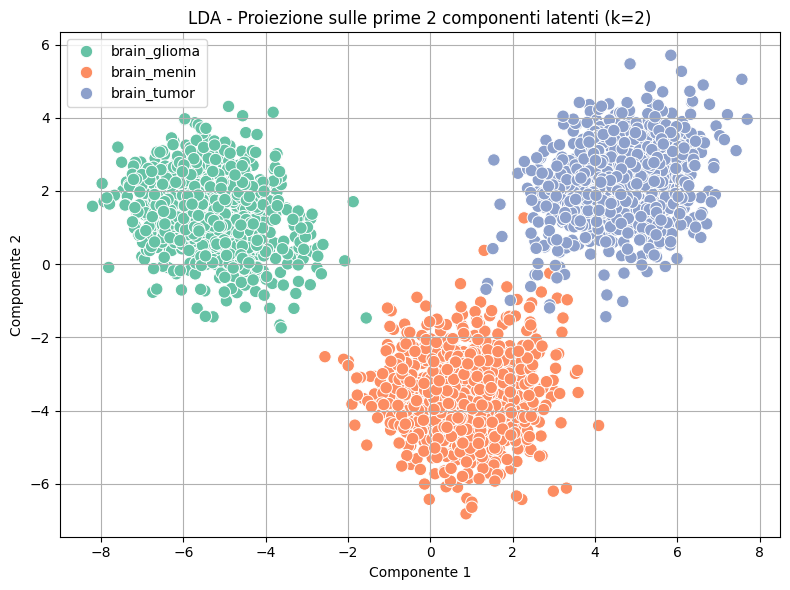

[SALVATO] Latent semantics salvati in: latent_semantics_lda_resnet_features_all_k2.txt


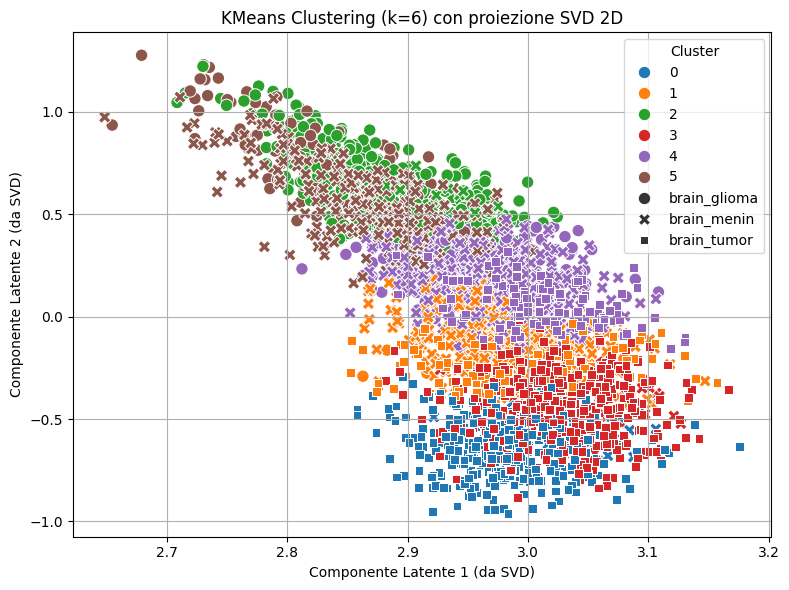

[SALVATO] Latent semantics salvati in: latent_semantics_kmeans_resnet_features_all_k6.txt


In [15]:
# Supponendo tu abbia salvato il file .npz come "resnet_layer3.npz"
task5_latent_semantics_resnet("resnet_features_all.npz", technique="svd", k=5)
task5_latent_semantics_resnet("resnet_features_all.npz", technique="lda", k=2)
task5_latent_semantics_resnet("resnet_features_all.npz", technique="kmeans", k=6)
